In [ ]:
#import necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [ ]:
# Step 1: Download the MNIST dataset
torchvision.datasets.MNIST(root='./data', train=True, download=True)
torchvision.datasets.MNIST(root='./data', train=False, download=True)

# Step 2: Load the raw MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

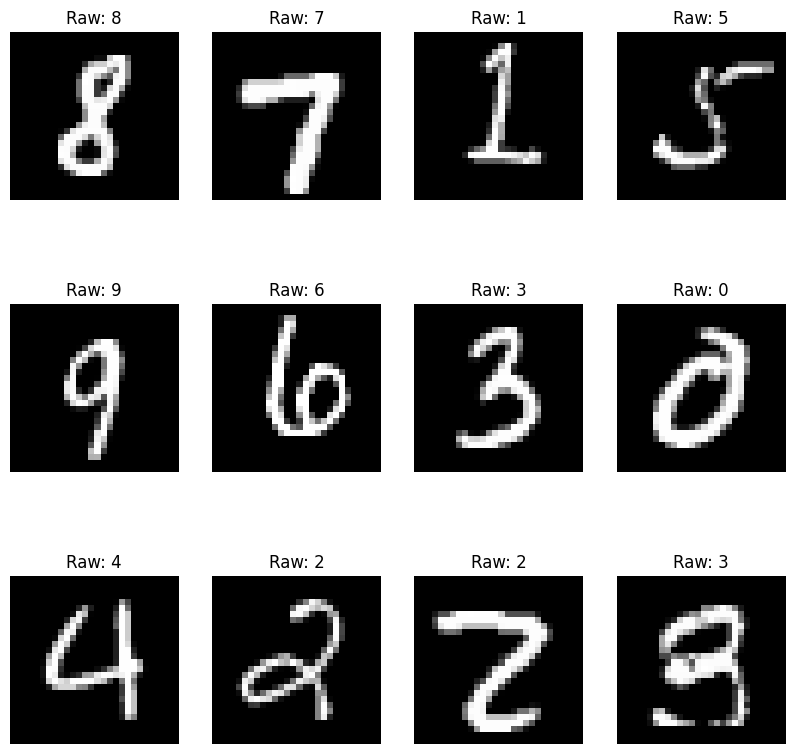

In [ ]:
# Visualize the datasets
def show_images(images, labels, label_header="True"):
    figure = plt.figure(figsize=(10, 10))
    rows, cols = 3, 4
    for i in range(1, rows*cols+1):
        figure.add_subplot(rows, cols, i)
        plt.axis(False)
        plt.title(f"{label_header}: {labels[i-1].item()}")
        plt.imshow(images[i-1].permute(1, 2, 0), cmap='gray')

    plt.show()

# Get a batch of images and show
images, labels = next(iter(trainloader))
show_images(images, labels, label_header="Raw")

In [ ]:
# Step 3: Preprocessing Step: Normalization and Data Augmentation
transform_train = transforms.Compose([
    transforms.RandomRotation(10),  # Randomly rotate the image by 10 degrees
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # Random translation
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to range [-1, 1]
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize the same way for test set
])

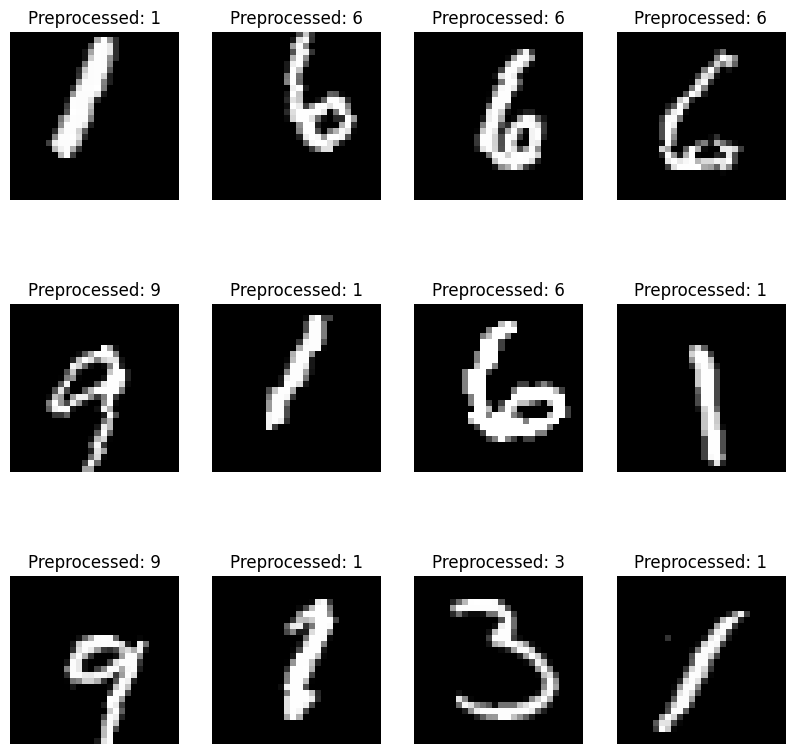

In [ ]:
# Step 4: Load the MNIST dataset with preprocessing applied
trainset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Visualize Some Preprocessed Images
preprocessed_images, preprocessed_labels = next(iter(trainloader))
show_images(preprocessed_images, preprocessed_labels, label_header="Preprocessed")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [ ]:
# Step 1: Define the MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # Flatten input (28x28) to 784
        self.flatten = nn.Flatten()
        # Define MLP layers
        self.fc1 = nn.Linear(28*28, 256)  # First fully connected layer
        self.fc2 = nn.Linear(256, 128)    # Second fully connected layer
        self.fc3 = nn.Linear(128, 64)     # Third fully connected layer
        self.fc4 = nn.Linear(64, 10)      # Output layer (10 classes)
        self.relu = nn.ReLU()             # ReLU activation function

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)  # No activation in the last layer (we'll use CrossEntropyLoss which combines softmax)
        return x

In [ ]:
# Step 2: Initialize model, loss function, and optimizer
model = MLP()
criterion = nn.CrossEntropyLoss()  # Cross entropy loss combines softmax and loss calculation
optimizer = optim.Adam(model.parameters(), lr=0.0009) # Adam optimizer

In [ ]:
# Step 3: Training function
def train(model, trainloader, criterion, optimizer, epochs=25):
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in trainloader:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Print statistics
        epoch_loss = running_loss / len(trainloader)
        accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Training Accuracy: {accuracy:.2f}%,")

In [ ]:
# Step 4: Evaluation function
def evaluate(model, testloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():  # Disable gradient calculation for inference
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())  # Convert lists to numpy arrays
            all_preds.extend(predicted.cpu().numpy())

     # Step 5: Compute evaluation metrics
    accuracy = accuracy_score(all_labels, all_preds) * 100
    precision = precision_score(all_labels, all_preds, average="weighted") * 100
    recall = recall_score(all_labels, all_preds, average="weighted") * 100
    f1 = f1_score(all_labels, all_preds, average="weighted") * 100

    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"Recall: {recall:.2f}%")
    print(f"F1 Score: {f1:.2f}%")


In [ ]:
# Step 6: Train the model
train(model, trainloader, criterion, optimizer, epochs=25)

# Step 7: Evaluate the model on the test set
evaluate(model, testloader)

Epoch [1/25], Loss: 0.1967, Training Accuracy: 93.86%,
Epoch [2/25], Loss: 0.1799, Training Accuracy: 94.38%,
Epoch [3/25], Loss: 0.1714, Training Accuracy: 94.62%,
Epoch [4/25], Loss: 0.1611, Training Accuracy: 94.90%,
Epoch [5/25], Loss: 0.1489, Training Accuracy: 95.28%,
Epoch [6/25], Loss: 0.1484, Training Accuracy: 95.27%,
Epoch [7/25], Loss: 0.1365, Training Accuracy: 95.74%,
Epoch [8/25], Loss: 0.1347, Training Accuracy: 95.80%,
Epoch [9/25], Loss: 0.1301, Training Accuracy: 95.89%,
Epoch [10/25], Loss: 0.1230, Training Accuracy: 96.13%,
Epoch [11/25], Loss: 0.1231, Training Accuracy: 96.08%,
Epoch [12/25], Loss: 0.1202, Training Accuracy: 96.24%,
Epoch [13/25], Loss: 0.1163, Training Accuracy: 96.42%,
Epoch [14/25], Loss: 0.1139, Training Accuracy: 96.46%,
Epoch [15/25], Loss: 0.1119, Training Accuracy: 96.42%,
Epoch [16/25], Loss: 0.1090, Training Accuracy: 96.57%,
Epoch [17/25], Loss: 0.1060, Training Accuracy: 96.70%,
Epoch [18/25], Loss: 0.1071, Training Accuracy: 96.56%,
E